In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ogw3-augmented/X_damage_augmented.npy
/kaggle/input/ogw3-augmented/X_freq_augmented.npy
/kaggle/input/ogw3-augmented/X_signals_augmented.npy
/kaggle/input/trained_800/keras/default/1/model_checkpoint_3.keras


# 1.5) loading augmented data

In [2]:
%pwd


'/kaggle/working'

In [3]:
import os

In [4]:
os.chdir("..")
os.chdir("input")

In [5]:
X_signals_augmented = np.load('ogw3-augmented/X_signals_augmented.npy')
X_damage_augmented = np.load('ogw3-augmented/X_damage_augmented.npy')
X_freq_augmented = np.load('ogw3-augmented/X_freq_augmented.npy')


In [6]:
print(f"X_signals shape:{X_signals_augmented.shape}")
print(f"X_signals shape:{X_damage_augmented.shape}")
print(f"X_signals shape:{X_freq_augmented.shape}")

X_signals shape:(2040, 4369, 1)
X_signals shape:(2040, 14)
X_signals shape:(2040, 12)


In [7]:
import numpy as np

def summarize_data(X, name):
    print(f"Summary for {name}:")
    print("Mean:", np.mean(X, axis=0))
    print("Variance:", np.var(X, axis=0))
    print("Min:", np.min(X, axis=0))
    print("Max:", np.max(X, axis=0))
    print("-" * 50)

summarize_data(X_signals_augmented, "X_signals_augmented")
summarize_data(X_freq_augmented, "X_freq_augmented")


Summary for X_signals_augmented:
Mean: [[-0.00808563]
 [-0.03676917]
 [ 0.00793156]
 ...
 [ 0.43494834]
 [ 0.47826858]
 [ 0.47794448]]
Variance: [[0.04756828]
 [0.05728288]
 [0.05182533]
 ...
 [0.11266843]
 [0.11778735]
 [0.1192308 ]]
Min: [[-1.]
 [-1.]
 [-1.]
 ...
 [-1.]
 [-1.]
 [-1.]]
Max: [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
--------------------------------------------------
Summary for X_freq_augmented:
Mean: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
Variance: [0.07638889 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889
 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889]
Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
--------------------------------------------------


In [8]:
import pandas as pd

damage_counts = pd.Series(X_damage_augmented.flatten()).value_counts()
print("Damage Condition Counts:\n", damage_counts)


Damage Condition Counts:
 0.0    26520
1.0     2040
Name: count, dtype: int64


# 2. Execution and model Training
This is where the actual execution starts

In [9]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------------------
# Step 1: Convert one-hot encoded damage labels to scalar values.
# ----------------------------------------------------------------------
# Each sample in X_damage_augmented is a one-hot vector. We convert it to the
# corresponding class index (i.e., 0 for undamaged, 1-13 for damage levels).
y_augmented = np.argmax(X_damage_augmented, axis=1).astype(np.float32)
# y_augmented now has shape (num_samples,)

In [11]:
y_augmented.min()

0.0

In [12]:
# ----------------------------------------------------------------------
# Step 2: Define the features.
# ----------------------------------------------------------------------
# For this regression task, we use the guided wave signals as the features.
# (If you wish to include frequency information as additional features, you might
# concatenate or process X_freq_augmented separately; here we assume only the signal is used.)
X_augmented = X_signals_augmented  # shape: (num_samples, 4369, 1)

In [13]:
# ----------------------------------------------------------------------
# Step 3: Split the data into training and test sets.
# ----------------------------------------------------------------------
# Here we use 80% of the data for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, test_size=0.1, random_state=42
)


In [14]:
# ----------------------------------------------------------------------
# Step 4: Verify the shapes of the datasets.
# ----------------------------------------------------------------------
print(f"Training data shape: {X_train.shape}")  # Expected: (num_train_samples, 4369, 1)
print(f"Training labels shape: {y_train.shape}")  # Expected: (num_train_samples,)
print(f"Test data shape: {X_test.shape}")         # Expected: (num_test_samples, 4369, 1)
print(f"Test labels shape: {y_test.shape}")         # Expected: (num_test_samples,)


Training data shape: (1836, 4369, 1)
Training labels shape: (1836,)
Test data shape: (204, 4369, 1)
Test labels shape: (204,)


In [15]:
def print_label_distribution(y, set_name):
    """Print the distribution of labels in a dataset."""
    print(f"\n{set_name} label distribution:")
    print(f"- Baseline samples (0): {np.sum(y == 0)}")
    for damage_size in range(1, 14):
        print(f"- Damage size {damage_size}: {np.sum(y == damage_size)}")

In [16]:
# Print label distribution for training and test sets
print_label_distribution(y_train, "Training set")
print_label_distribution(y_test, "Test set")


Training set label distribution:
- Baseline samples (0): 433
- Damage size 1: 107
- Damage size 2: 107
- Damage size 3: 105
- Damage size 4: 106
- Damage size 5: 105
- Damage size 6: 107
- Damage size 7: 115
- Damage size 8: 109
- Damage size 9: 107
- Damage size 10: 111
- Damage size 11: 109
- Damage size 12: 111
- Damage size 13: 104

Test set label distribution:
- Baseline samples (0): 47
- Damage size 1: 13
- Damage size 2: 13
- Damage size 3: 15
- Damage size 4: 14
- Damage size 5: 15
- Damage size 6: 13
- Damage size 7: 5
- Damage size 8: 11
- Damage size 9: 13
- Damage size 10: 9
- Damage size 11: 11
- Damage size 12: 9
- Damage size 13: 16


In [17]:
# Convert input data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [18]:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [19]:
print("Min values after scaling:", np.min(X_train, axis=(1,2)))
print("Max values after scaling:", np.max(X_train, axis=(1,2)))

Min values after scaling: [-1.040155  -0.9812768 -1.        ... -1.        -0.9722817 -0.9399686]
Max values after scaling: [1.0318567  0.94322634 1.         ... 1.         0.9312466  1.0010613 ]


In [20]:
print("X_train dtype:", X_train.dtype)  # Should print float32
print("y_train dtype:", y_train.dtype)  # Should print float32

X_train dtype: float32
y_train dtype: int32


# 3. Model Architecture

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

In [22]:
tf.keras.backend.set_floatx('float32')

In [23]:
# Multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

In [24]:
%pwd

'/kaggle/input'

In [25]:
# Assume X_train has the shape (num_samples, 4369, 1)
num_samples, original_length, channels = X_train.shape

# Calculate padding length so that the length becomes divisible by 5.
pad_len = 1

# Pad along the sequence axis (axis=1) with -np.inf so that the max operation is not affected.
X_train_padded = np.pad(
    X_train,
    pad_width=((0, 0), (0, pad_len), (0, 0)),
    mode='constant',
    constant_values=-np.inf
)

# Now X_train_padded has the shape (num_samples, 4370, 1).


In [26]:
X_train_padded.shape

(1836, 4370, 1)

In [27]:

# Reshape to group every 5 consecutive elements:
# New shape will be (num_samples, 874, 5, 1)
grouped_length = X_train_padded.shape[1] // 5  # Should be 874
X_train_grouped = X_train_padded.reshape(num_samples, grouped_length, 5, channels)

# Take the max over the 5 elements for each group (axis=2)
# Resulting shape is (num_samples, 874, 1)
X_train_max = np.max(X_train_grouped, axis=2)

# Optionally, if your model expects inputs of shape (num_samples, 874),
# reshape the array from (num_samples, 874, 1) to (num_samples, 874)
X_train_final = X_train_max.reshape(num_samples, grouped_length)

# Check the resulting shape
print("Shape after max-pooling and reshaping:", X_train_final.shape)


Shape after max-pooling and reshaping: (1836, 874)


In [28]:
# Assume X_train has the shape (num_samples, 4369, 1)
num_samples, original_length, channels = X_test.shape

# Calculate padding length so that the length becomes divisible by 5.
pad_len = 1

# Pad along the sequence axis (axis=1) with -np.inf so that the max operation is not affected.
X_test_padded = np.pad(
    X_test,
    pad_width=((0, 0), (0, pad_len), (0, 0)),
    mode='constant',
    constant_values=-np.inf
)

# Now X_train_padded has the shape (num_samples, 4370, 1).

# Reshape to group every 5 consecutive elements:
# New shape will be (num_samples, 874, 5, 1)
grouped_length = X_test_padded.shape[1] // 5  # Should be 874
X_test_grouped = X_test_padded.reshape(num_samples, grouped_length, 5, channels)

# Take the max over the 5 elements for each group (axis=2)
# Resulting shape is (num_samples, 874, 1)
X_test_max = np.max(X_test_grouped, axis=2)

# Optionally, if your model expects inputs of shape (num_samples, 874),
# reshape the array from (num_samples, 874, 1) to (num_samples, 874)
X_test_final = X_test_max.reshape(num_samples, grouped_length)

# Check the resulting shape
print("Shape after max-pooling and reshaping:", X_test_final.shape)


Shape after max-pooling and reshaping: (204, 874)


In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save every epoch
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.keras',  # Save file with epoch number and .keras extension
    save_weights_only=False,  # Save the full model
    save_freq='epoch',  # Save at the end of each epoch
    verbose=1  # To print a message when the model is saved
)

# Modify the callbacks list to include the checkpoint callback 
callbacks = [
    keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
    checkpoint_callback
]


In [30]:
%pwd

'/kaggle/input'

In [31]:

# Load the model within the strategy scope
with strategy.scope():
    model_loaded = load_model('/kaggle/input/trained_800/keras/default/1/model_checkpoint_3.keras')

In [32]:
os.chdir("..")
os.chdir("working")

In [33]:
%pwd

'/kaggle/working'

# evaluating the model

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [36]:
# Evaluate the model on the test data
loss, accuracy = model_loaded.evaluate(X_test_final, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.6662 - loss: 1.6906
Test Loss: 1.641147494316101
Test Accuracy: 0.6666666865348816


In [37]:
# Make predictions on the test data
y_pred = model_loaded.predict(X_test_final, batch_size=32)

# Convert predictions to integer values (since you are doing multi-class classification, predictions are probably probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to integer labels if they are not already
y_test_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step


In [38]:

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        47
           1       0.64      0.69      0.67        13
           2       0.82      0.69      0.75        13
           3       1.00      0.47      0.64        15
           4       0.73      0.79      0.76        14
           5       0.60      0.80      0.69        15
           6       0.73      0.62      0.67        13
           7       0.44      0.80      0.57         5
           8       0.58      0.64      0.61        11
           9       0.64      0.54      0.58        13
          10       0.31      0.44      0.36         9
          11       0.54      0.64      0.58        11
          12       0.43      0.33      0.38         9
          13       0.75      0.38      0.50        16

    accuracy                           0.65       204
   macro avg       0.64      0.62      0.61       204
weighted avg       0.68      0.65      0.65       204



In [39]:






# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))


Confusion Matrix:
[[39  2  1  0  0  1  1  1  0  1  1  0  0  0]
 [ 2  9  0  0  0  1  0  0  0  0  0  0  0  1]
 [ 2  1  9  0  0  0  0  1  0  0  0  0  0  0]
 [ 3  1  0  7  1  2  0  0  0  1  0  0  0  0]
 [ 1  0  0  0 11  0  1  0  0  1  0  0  0  0]
 [ 2  0  0  0  0 12  0  0  0  0  1  0  0  0]
 [ 2  1  0  0  0  1  8  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  1  1  7  0  0  0  0  1]
 [ 0  0  1  0  0  1  0  0  0  7  3  0  1  0]
 [ 1  0  0  0  0  1  0  0  0  0  4  2  1  0]
 [ 0  0  0  0  0  0  0  0  2  1  1  7  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  1  3  3  0]
 [ 0  0  0  0  3  1  0  1  1  0  1  1  2  6]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step


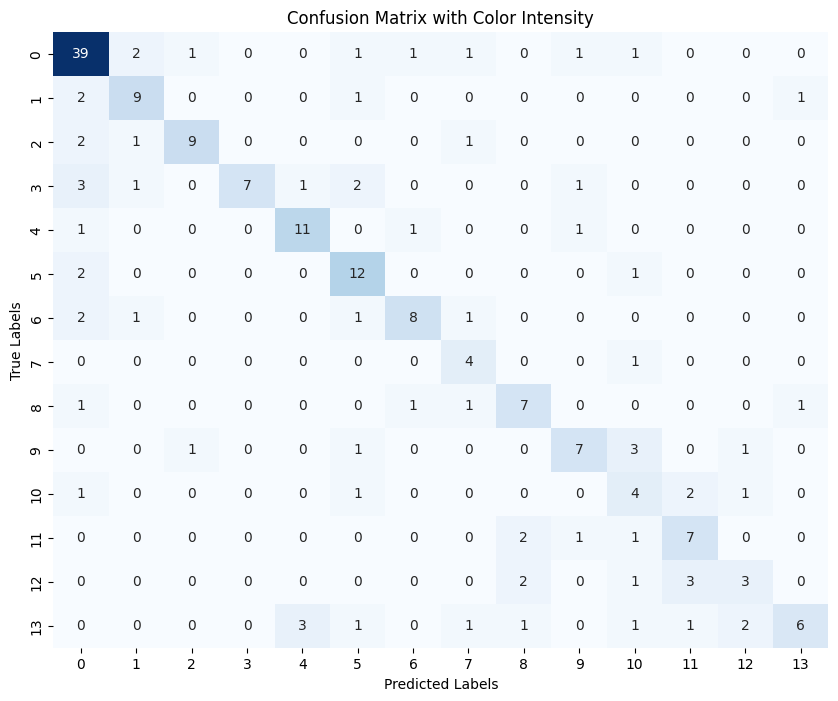

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test data
y_pred = model_loaded.predict(X_test_final, batch_size=32)

# Convert predictions to integer values (since it's multi-class classification)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to integer labels if needed
y_test_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix with color intensity
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.arange(14), yticklabels=np.arange(14))

# Labels and title
plt.title('Confusion Matrix with Color Intensity')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


In [41]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        47
           1       0.64      0.69      0.67        13
           2       0.82      0.69      0.75        13
           3       1.00      0.47      0.64        15
           4       0.73      0.79      0.76        14
           5       0.60      0.80      0.69        15
           6       0.73      0.62      0.67        13
           7       0.44      0.80      0.57         5
           8       0.58      0.64      0.61        11
           9       0.64      0.54      0.58        13
          10       0.31      0.44      0.36         9
          11       0.54      0.64      0.58        11
          12       0.43      0.33      0.38         9
          13       0.75      0.38      0.50        16

    accuracy                           0.65       204
   macro avg       0.64      0.62      0.61       204
weighted avg       0.68      0.65      0.65       204



In [42]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score for multi-class classification
auc_roc = roc_auc_score(y_test_classes, y_pred, average='macro', multi_class='ovr')
print(f'AUC-ROC Score: {auc_roc}')


AUC-ROC Score: 0.8750312862217543


In [43]:
from sklearn.metrics import log_loss

# Calculate Log Loss
log_loss_value = log_loss(y_test_classes, y_pred)
print(f'Log Loss: {log_loss_value}')


Log Loss: 1.7878827662080623


In [44]:
from sklearn.metrics import matthews_corrcoef

# Calculate MCC
mcc = matthews_corrcoef(y_test_classes, y_pred_classes)
print(f'MCC: {mcc}')


MCC: 0.6134087094118695


In [46]:
from sklearn.metrics import cohen_kappa_score

# Calculate Kappa
kappa = cohen_kappa_score(y_test_classes, y_pred_classes)
print(f'Cohen Kappa: {kappa}')


Cohen Kappa: 0.6113868691475945


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step


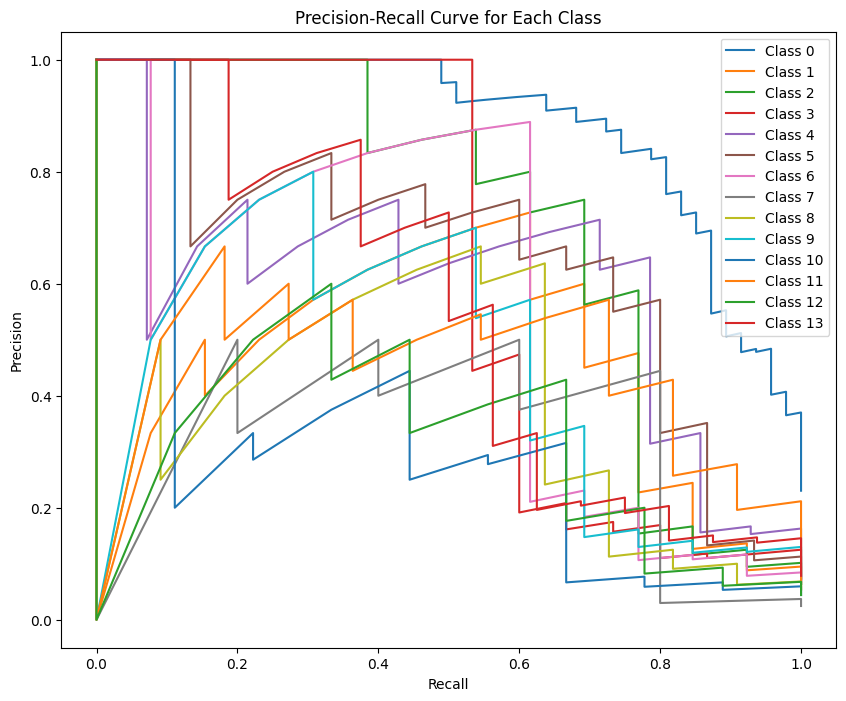

In [48]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class classification (one-vs-rest)
y_test_binarized = label_binarize(y_test_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Get predicted probabilities for each class
y_pred_probs = model_loaded.predict(X_test_final)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

for i in range(14):  # Loop over the classes (0 to 13)
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()


# training evaluation

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             log_loss, matthews_corrcoef, cohen_kappa_score, precision_recall_curve)
from sklearn.preprocessing import label_binarize

In [50]:
# 1. Evaluate the model on the training data
train_loss, train_accuracy = model_loaded.evaluate(X_train_final, y_train, verbose=1)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)

58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 451ms/step - accuracy: 1.0000 - loss: 0.1134
Training Loss: 0.11031132191419601
Training Accuracy: 1.0


In [51]:
# 2. Make predictions on the training data
y_train_pred_probs = model_loaded.predict(X_train_final, batch_size=32)
y_train_pred_classes = np.argmax(y_train_pred_probs, axis=1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step


In [52]:
# Ensure training labels are in the proper format (integer encoded)
y_train_classes = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train

In [53]:
# 3. Classification Report
print("Classification Report on Training Set:")
print(classification_report(y_train_classes, y_train_pred_classes))

Classification Report on Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       433
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       107
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00       106
           5       1.00      1.00      1.00       105
           6       1.00      1.00      1.00       107
           7       1.00      1.00      1.00       115
           8       1.00      1.00      1.00       109
           9       1.00      1.00      1.00       107
          10       1.00      1.00      1.00       111
          11       1.00      1.00      1.00       109
          12       1.00      1.00      1.00       111
          13       1.00      1.00      1.00       104

    accuracy                           1.00      1836
   macro avg       1.00      1.00      1.00      1836
weighted avg       1.00      1.00      1.

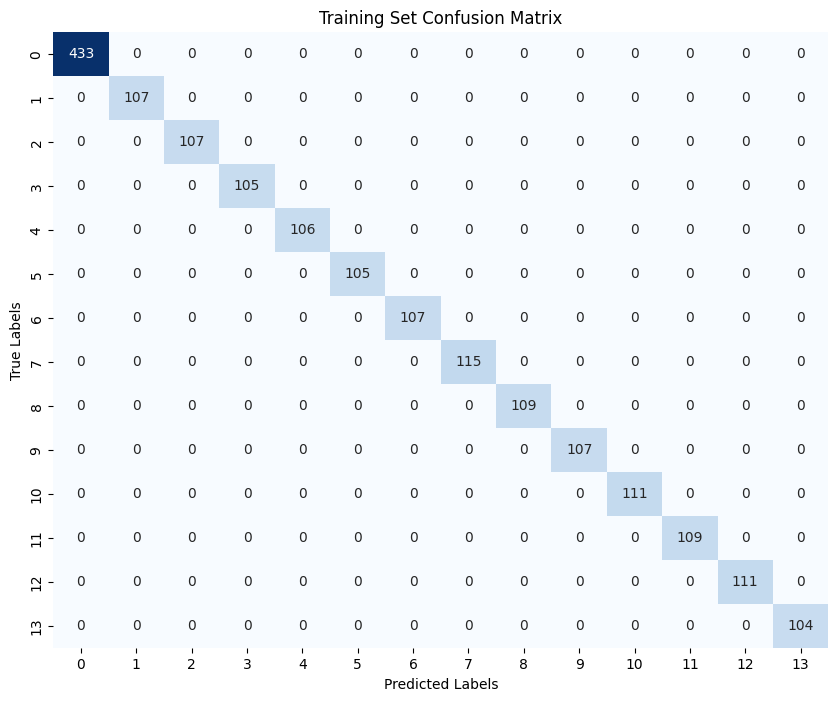

In [54]:
# 4. Confusion Matrix (with a colorful heatmap)
cm_train = confusion_matrix(y_train_classes, y_train_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(14), yticklabels=np.arange(14))
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [55]:
# 5. AUC-ROC Score for multi-class (One-vs-Rest)
auc_roc_train = roc_auc_score(y_train_classes, y_train_pred_probs, average='macro', multi_class='ovr')
print("AUC-ROC Score (Training):", auc_roc_train)


AUC-ROC Score (Training): 1.0


In [56]:
# 6. Log Loss
log_loss_train = log_loss(y_train_classes, y_train_pred_probs)
print("Log Loss (Training):", log_loss_train)

Log Loss (Training): 0.11315993104829397


In [57]:
# 7. Matthews Correlation Coefficient (MCC)
mcc_train = matthews_corrcoef(y_train_classes, y_train_pred_classes)
print("Matthews Correlation Coefficient (Training):", mcc_train)

Matthews Correlation Coefficient (Training): 1.0


In [58]:
# 8. Cohen's Kappa Score
kappa_train = cohen_kappa_score(y_train_classes, y_train_pred_classes)
print("Cohen's Kappa (Training):", kappa_train)

Cohen's Kappa (Training): 1.0


In [59]:
# 9. Precision-Recall Curve for each class (One-vs-Rest)
# Binarize the training labels
y_train_binarized = label_binarize(y_train_classes, classes=list(range(14)))

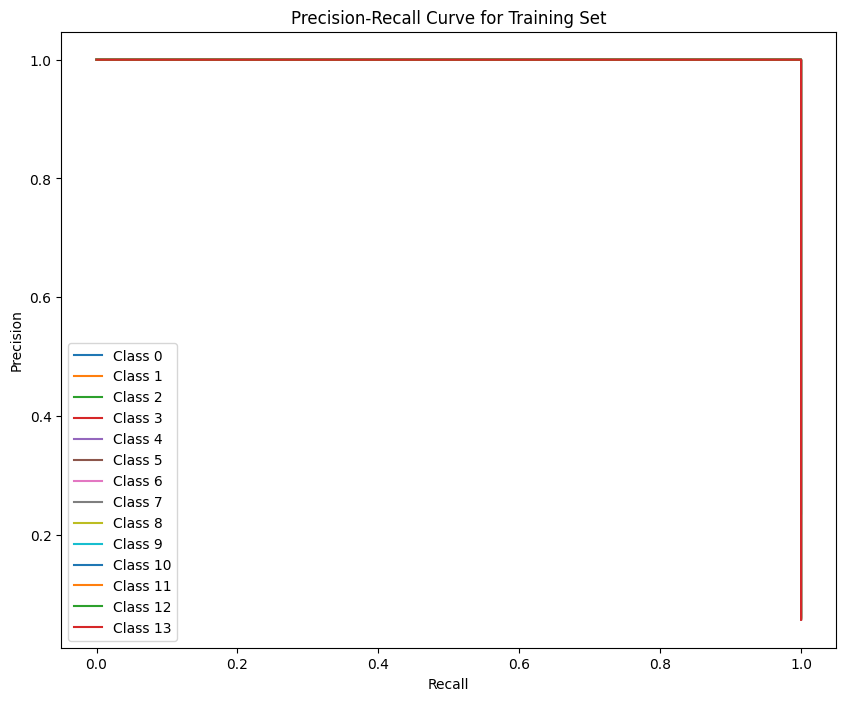

In [60]:
plt.figure(figsize=(10, 8))
for i in range(14):
    precision, recall, _ = precision_recall_curve(y_train_binarized[:, i], y_train_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Training Set')
plt.legend(loc='best')
plt.show()
